In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             accuracy_score, precision_score, roc_curve, recall_score,f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib


In [2]:

# =========== 1) Carregar base ===========
"""
Dados brutos convertidos em parquet para melhor compactação e uso
"""
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
file_path = os.path.join(ROOT, "dataset", "DENGBR25.parquet")

df = pd.read_parquet(file_path)

# =========== 2) Criar variável target (Dengue comum x grave) ===========
map_classi_fin = {
    10: 0,   # Dengue comum
    11: 1,   # Dengue com sinais de alarme
    12: 1,   # Dengue grave
    8: None, # Inconclusivo -> descartar
    13: None # Chikungunya -> descartar
}
df["target"] = df["CLASSI_FIN"].map(map_classi_fin)

# Remover NaN do target e sexo (I-ignorado)
df = df.dropna(subset=["target"]).copy()
df = df.loc[df['CS_SEXO'] != 'I'].copy()
df["target"] = df["target"].astype(int)

In [3]:
# =========== 3) Selecionar colunas de interesse ===========
usecols = [
    'NU_IDADE_N','CS_SEXO','CS_GESTANT',
    'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA',
    'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N',
    'LEUCOPENIA', 'LACO', 'DOR_RETRO',
    'DIABETES', 'HEMATOLOG','HEPATOPAT','RENAL','HIPERTENSA',
    'ACIDO_PEPT','AUTO_IMUNE',
    'DT_NOTIFIC','DT_SIN_PRI',
    'CLASSI_FIN','target'
]
df_dengue = df[usecols].copy()

#Mantendo nomes das colunas em caixa baixa
df_dengue.columns = df_dengue.columns.str.lower()
df_dengue.head(1)

,nu_idade_n,cs_sexo,cs_gestant,febre,mialgia,cefaleia,exantema,vomito,nausea,dor_costas,...,hematolog,hepatopat,renal,hipertensa,acido_pept,auto_imune,dt_notific,dt_sin_pri,classi_fin,target
0,4059,F,5.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2025-01-06,2025-01-01,10.0,0


In [4]:
# =========== 4) Nova Feature e Ajustes ===========
df_dengue['dt_notific'] = pd.to_datetime(df_dengue['dt_notific'])
df_dengue['dt_sin_pri'] = pd.to_datetime(df_dengue['dt_sin_pri'])
df_dengue['dias_sintomas'] = (df_dengue['dt_notific'] - df_dengue['dt_sin_pri']).dt.days
df_dengue = df_dengue.drop(['dt_notific','dt_sin_pri'], axis=1)


#Ajustando Sexo para binario
df_dengue['cs_sexo'] = df_dengue['cs_sexo'].map({'M': 0, 'F': 1})

In [5]:

# =========== 5) Idade -> faixa_etaria / Gestante Agrupamento -> gestante_cat ===========
def faixa_etaria(idade):
    if pd.isna(idade):
        return 'Nao Informado'
    if idade <= 11:
        return 'Crianca'
    elif idade <= 17:
        return 'Adolescente'
    elif idade <= 59:
        return 'Adulto'
    else:
        return 'Idoso'

df_dengue = df_dengue.loc[df_dengue['nu_idade_n'] > 1000].copy() # Removido 3 linhas menor que 1000
df_dengue['nu_idade_n'] = df_dengue['nu_idade_n'].astype(str).str.slice(start=1).astype(int)
df_dengue['faixa_etaria'] = df_dengue['nu_idade_n'].apply(faixa_etaria)
df_dengue = df_dengue.loc[df_dengue['nu_idade_n'] < 121].copy() # Removido 28 registros caracterizado como erro de idade
df_dengue.drop('nu_idade_n', axis=1, inplace=True)

def agrupa_gestante(x):
    if x in [1, 2, 3]:              # 1º Trimestre / 2º Trimestre / 3º Trimestre
        return "gestante"
    elif x == 5:                    # Não
        return "nao"
    elif x == 6:                    # Não se aplica
        return "nao_aplica"
    elif x in [4, 9] or pd.isna(x): # 4 Idade gestacional ignorada, 9 Ignorado
        return "ignorado"
    else:
        return "ignorado"  # Para valores inesperados
    
df_dengue = df_dengue.dropna(subset=['cs_gestant']) # Removendo os NaN antes da classificação = 110
df_dengue['gestante_cat'] = df_dengue['cs_gestant'].apply(agrupa_gestante)

In [6]:
# =========== 6) Sintomas/comorbidades 1-'Sim' e 2-'Não' -> binário (1/0) ===========
for col in ['febre', 'mialgia', 'cefaleia', 'exantema', 'vomito', 'nausea', 
            'dor_costas', 'conjuntvit', 'artrite', 'artralgia', 'petequia_n', 
            'leucopenia', 'laco', 'dor_retro',
            'diabetes', 'hematolog', 'hepatopat', 'renal', 
            'hipertensa', 'acido_pept', 'auto_imune']:
    df_dengue[col] = df_dengue[col].map({1.0: 1, 2.0: 0})
    df_dengue[col] = df_dengue[col].fillna(0).astype(int) #No dataset existem 4 registros q ficaram sem, incluindo no Não pela baixa relevancia

df_dengue.drop(columns=['cs_gestant'], inplace=True) # Mantendo apenas a coluna de categoria criada

In [7]:
# =========== 7) Separando features (X) e target/class (y) ===========
X = df_dengue.drop(['target','classi_fin'], axis=1)
y = df_dengue['target']

# One-Hot Encoding para transformar as variaveis categorias em binarias
X = pd.get_dummies(X, columns=['faixa_etaria','gestante_cat'], drop_first=True)

In [8]:
# =========== 8) Separando treino/teste ===========
# Dividindo o conjunto de dados em 80% para treinamento e 20% para testes.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Testando modelos - Inicial

In [9]:
# =========== 9) Modelo 1: Regressão Logística ===========
log_reg_model = LogisticRegression(
    class_weight='balanced',  # ajusta pesos automaticamente para lidar com desbalanceamento
    max_iter=10000,           # número máximo de iterações para garantir convergência 
    random_state=42           # garante consistência nos resultados
)

log_reg_model.fit(X_train, y_train)
y_pred_log = log_reg_model.predict(X_test)
y_proba_log = log_reg_model.predict_proba(X_test)[:,1]

# =========== AVALIAÇÃO ===========
print("\n--- Regressão Logística ---")
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("AUC:", roc_auc_score(y_test, y_proba_log))


--- Regressão Logística ---
Matriz de Confusão:
 [[165909  70724]
 [  2578   3827]]
              precision    recall  f1-score   support

           0       0.98      0.70      0.82    236633
           1       0.05      0.60      0.09      6405

    accuracy                           0.70    243038
   macro avg       0.52      0.65      0.46    243038
weighted avg       0.96      0.70      0.80    243038

AUC: 0.7017404791425405


In [10]:
# =========== 10) Modelo 2: XGBoost ===========

#Calcular scale_pos_weight (proporção entre classes negativa/positiva)
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"scale_pos_weight = {scale_pos_weight:.2f}")


xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',        # problema de classificação binária
    eval_metric='auc',                  # métrica principal AUC (robusta ao desbalanceamento)
    use_label_encoder=False,
    random_state=42,                    # garante consistência nos resultados
    n_jobs=-1,                          # usa todos os núcleos disponíveis para treinar mais rápido
    scale_pos_weight=scale_pos_weight   # ajuste para desbalanceamento
)

xgb_model.fit(X_train, y_train)

# =========== AVALIAÇÃO ===========
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

print("\n--- XGBoost ---")
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_proba_xgb))

scale_pos_weight = 36.94


c:\prj-modelo-ml\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:41:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Matriz de Confusão:
 [[172803  63830]
 [  2487   3918]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    236633
           1       0.06      0.61      0.11      6405

    accuracy                           0.73    243038
   macro avg       0.52      0.67      0.47    243038
weighted avg       0.96      0.73      0.82    243038

AUC: 0.72454164893523


In [11]:
# =========== 11) Modelo 3: DecisionTreeClassifier ===========

dt_model = DecisionTreeClassifier(
    max_depth=5,              # limita a profundidade da árvore (evita overfitting)
    min_samples_split=50,     # exige pelo menos 50 amostras para dividir um nó
    class_weight='balanced',  # ajusta pesos para lidar com classes desbalanceadas
    random_state=42           # garante consistência nos resultados
)

dt_model.fit(X_train, y_train)
y_pred_tree = dt_model.predict(X_test)
y_proba_tree = dt_model.predict_proba(X_test)[:, 1]

print("\n--- Decision Tree ---")
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_tree))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_tree))
print("AUC:", roc_auc_score(y_test, y_proba_tree))


--- Decision Tree ---
Matriz de Confusão:
 [[158785  77848]
 [  2428   3977]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.98      0.67      0.80    236633
           1       0.05      0.62      0.09      6405

    accuracy                           0.67    243038
   macro avg       0.52      0.65      0.44    243038
weighted avg       0.96      0.67      0.78    243038

AUC: 0.702506494038224


# Tuning hiperparam - Conferindo melhores modelos
- Etapa demora em média uns ~25min para conferir os melhores parametros, sendo:
- ~8min para LogisticRegression
- ~12min para XGBClassifier
- ~3min para DecisionTreeClassifier

### LogisticRegression

In [12]:
# Grade de parâmetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],   # força da regularização
    'penalty': ['l1', 'l2'],   # tipo de regularização
    'solver': ['liblinear']    # bom para bases grande
}

# Busca com validação cruzada
lg_grid_search = GridSearchCV(
    estimator=log_reg_model, # Modelo Base Teste Inicial
    param_grid=param_grid,
    scoring='roc_auc',  # pode trocar para f1, recall, etc.
    cv=3,               # 3-fold para não pesar
    verbose=1,
    n_jobs=-1
)

# Treino
lg_grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", lg_grid_search.best_params_)
print("Melhor AUC (cross-val):", lg_grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Melhores parâmetros: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Melhor AUC (cross-val): 0.7030624558688


### XGBClassifier

In [13]:
# Grade pequena de parâmetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Busca simples
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid, # Modelo Base Teste Inicial
    scoring='roc_auc',
    cv=3,            # 3-fold (leve)
    verbose=1,
    n_jobs=-1
)

xgb_grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", xgb_grid_search.best_params_)
print("Melhor AUC (cross-val):", xgb_grid_search.best_score_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\prj-modelo-ml\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores parâmetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Melhor AUC (cross-val): 0.7319667341430104


### DecisionTreeClassifier

In [14]:
# Grade de parâmetros
param_grid = {
    'max_depth': [3, 5, 7, None],        # profundidade da árvore
    'min_samples_split': [2, 10, 20],    # mínimo para dividir um nó
    'min_samples_leaf': [1, 5, 10]       # mínimo de amostras em uma folha
}

# Busca com validação cruzada
dt_grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid, # Modelo Base Teste Inicial
    scoring='roc_auc',   # métrica principal
    cv=3,                # 3-fold para não pesar
    verbose=1,
    n_jobs=-1
)

# Treino
dt_grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", dt_grid_search.best_params_)
print("Melhor AUC (cross-val):", dt_grid_search.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Melhores parâmetros: {'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}
Melhor AUC (cross-val): 0.7127452554946693


# Avaliação dos Modelos


=== LogisticRegression ===
Accuracy: 0.6983763855857932
Precision: 0.05130715885769473
Recall: 0.5971896955503513
F1: 0.09449577548297841
ROC AUC: 0.7017019995452531

=== XGBClassifier ===
Accuracy: 0.7077905512718176
Precision: 0.05601594173022745
Recall: 0.6363778298204528
F1: 0.10296829607174435
ROC AUC: 0.7307108601354523

=== DecisionTreeClassifier ===
Accuracy: 0.6940684172845398
Precision: 0.05259692372524231
Recall: 0.623575331772053
F1: 0.09701120948251782
ROC AUC: 0.7126012555805304


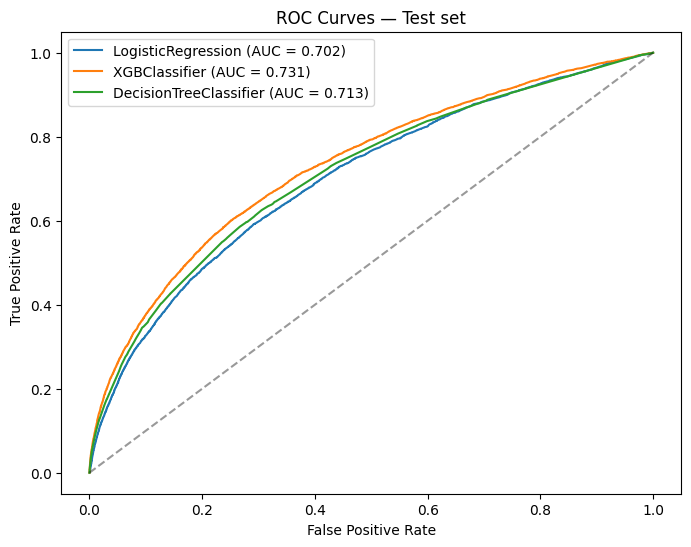

,accuracy,precision,recall,f1,roc_auc
XGBClassifier,0.707791,0.056016,0.636378,0.102968,0.730711
DecisionTreeClassifier,0.694068,0.052597,0.623575,0.097011,0.712601
LogisticRegression,0.698376,0.051307,0.597190,0.094496,0.701702


Melhor modelo segundo ROC AUC: XGBClassifier


In [15]:
# ======= AVALIAÇÃO NO TEST SET: comparar os 3 modelos ajustados =======
# Preparar os "melhores" modelos
best_lr = lg_grid_search.best_estimator_
best_gb = xgb_grid_search.best_estimator_
best_td = dt_grid_search.best_estimator_

final_models = {
    "LogisticRegression": best_lr,
    "XGBClassifier": best_gb,
    "DecisionTreeClassifier": best_td
}

# Treinar cada modelo no conjunto inteiro de treino
results_test = {}
plt.figure(figsize=(8,6))
for name, model in final_models.items():
    # Predições
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]  # prob of positive class
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    rocauc = roc_auc_score(y_test, y_proba)
    results_test[name] = {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "roc_auc":rocauc}
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    print("ROC AUC:", rocauc)
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {rocauc:.3f})")

plt.plot([0,1],[0,1],"k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Test set")
plt.legend()
plt.show()

# Mostrar resultados agregados
res_test_df = pd.DataFrame(results_test).T
display(res_test_df.sort_values("roc_auc", ascending=False))

# Escolher "melhor" modelo segundo métrica (por exemplo ROC AUC ou F1)
# Aqui escolhemos por ROC AUC:
best_name = res_test_df["roc_auc"].idxmax()
print("Melhor modelo segundo ROC AUC:", best_name)

# Execução com o melhor Modelo

In [19]:
# =========== Execução XGBoost ===========

#Calcular scale_pos_weight (proporção entre classes negativa/positiva)
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"scale_pos_weight = {scale_pos_weight:.2f}")


modelo_final = xgb.XGBClassifier(
    objective='binary:logistic',        # problema de classificação binária
    eval_metric='auc',                  # métrica principal AUC (robusta ao desbalanceamento)
    use_label_encoder=False,
    random_state=42,                    # garante consistência nos resultados
    n_jobs=-1,                          # usa todos os núcleos disponíveis para treinar mais rápido
    scale_pos_weight=scale_pos_weight,  # ajuste para desbalanceamento
    # melhores parâmetros encontrados no tuning
    colsample_bytree=0.8,               # fração de colunas usada em cada árvore (regularização)
    learning_rate=0.1,                  # taxa de aprendizado (quanto menor, mais conservador o treino)
    max_depth=3,                        # profundidade máxima das árvores (controla complexidade)
    n_estimators=200,                   # número de árvores (iterações de boosting)
    subsample=1.0                       # fração das amostras usada por árvore (evita overfitting)
)

modelo_final.fit(X_train, y_train)

# =========== AVALIAÇÃO ===========
y_pred_xgb_final = modelo_final.predict(X_test)
y_proba_xgb_final = modelo_final.predict_proba(X_test)[:,1]

print("\n--- XGBoost ---")
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_xgb_final))
print(classification_report(y_test, y_pred_xgb_final))
print("AUC:", roc_auc_score(y_test, y_proba_xgb_final))

scale_pos_weight = 36.94


c:\prj-modelo-ml\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:17:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Matriz de Confusão:
 [[167944  68689]
 [  2329   4076]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    236633
           1       0.06      0.64      0.10      6405

    accuracy                           0.71    243038
   macro avg       0.52      0.67      0.46    243038
weighted avg       0.96      0.71      0.81    243038

AUC: 0.7307108601354523


# Salvando Modelo

In [20]:
file_modelo = os.path.join(ROOT, "models", "xgb_model.pkl")
joblib.dump(xgb_model, file_modelo)

['c:\\prj-modelo-ml\\models\\xgb_model.pkl']